In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib
import imageio
import warnings
warnings.filterwarnings('ignore')
from src.utils import *
from src.nets import *

duration: 0.015s
dice: 0.07 -> 0.66
mean contour distance: 23.88 -> 3.28 px
Jacobians: stddev = 0.489, negatives = 1.156250%


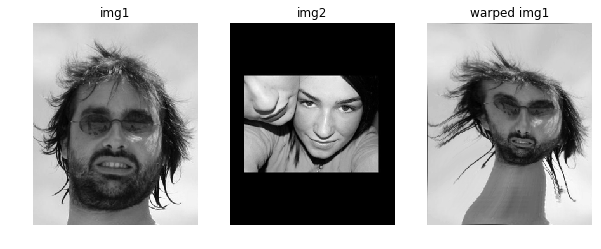

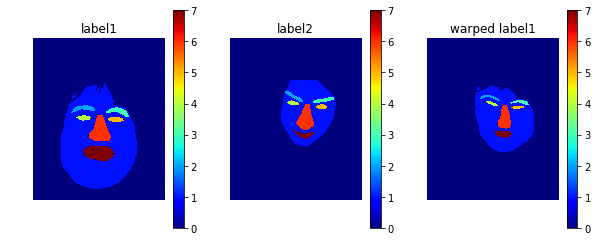

In [9]:
### load models ####
unet = torch.load('./models/unet.pth')
regnet1 = torch.load('./models/regnet1.pth')
regnet2 = torch.load('./models/regnet2.pth')
unet.eval()
regnet1.eval()
regnet2.eval()


### load data###
img1 = torch.from_numpy((np.asarray(imageio.imread('./data/img3.png')[:,:,0])/255).astype(np.float32)).unsqueeze(0).unsqueeze(0)
img2 = torch.from_numpy((np.asarray(imageio.imread('./data/img2.png')[:,:,0])/255).astype(np.float32)).unsqueeze(0).unsqueeze(0)
label1 = torch.from_numpy((np.asarray(imageio.imread('./data/seg3.png')[:,:,0]//36).astype(np.uint8))).unsqueeze(0).float()
label2 = torch.from_numpy((np.asarray(imageio.imread('./data/seg2.png')[:,:,0]//36).astype(np.uint8))).unsqueeze(0).float()
L = int(label1.max().item()+1)
label_y1 = labelMatrixOneHot(label1,L)
label_y2 = labelMatrixOneHot(label2,L)

ts = time.time()
with torch.no_grad():
    seg_predict1 = unet(img1.cuda())
    seg_predict2 = unet(img2.cuda())
    predflow_ = regnet1(torch.cat((seg_predict1,seg_predict2),1))
    warped_mov1, estflow1 = BsplineTrafo(seg_predict2,predflow_,19)
    predflow = regnet2(torch.cat((seg_predict1,warped_mov1),1))
    warped_mov2, estflow2 = BsplineTrafo(warped_mov1.float().cuda(), predflow, 11)
    def_x2 = estflow1 + estflow2

# upsample the deformation field in original image size
def_x2_up = F.upsample(def_x2,scale_factor=2)
print('duration: %.3fs'%(time.time()-ts))

### evaluation ###
warped_gt = warpImage(label_y2.float(),def_x2_up.cpu())
warped_im = warpImage(img2.cuda(),def_x2_up).cpu()

Jstd = torch.std(jacobian_det(def_x2_up.cpu()))
Jnegative = (jacobian_det(def_x2_up.cpu())<0).float().mean()

dice_before = dice_coeff(label_y1,label2,L)
dice_after = dice_coeff(warped_gt,label1,L)
asd_before= meancontourdist(label_y1.squeeze(),label_y2.squeeze())
asd_after = meancontourdist(torch.round(warped_gt).cpu().squeeze(),label_y1.squeeze())

print('dice: %.2f -> %.2f'%(dice_before.mean(),dice_after.mean()))
print('mean contour distance: %.2f -> %.2f px'%(asd_before.mean(), asd_after.mean()))
print('Jacobians: stddev = %.3f, negatives = %.6f%%'%(Jstd, Jnegative*100))

### result visualization ####
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(img1.squeeze(),'gray');plt.axis('off'); plt.title('img1')
plt.subplot(132)
plt.imshow(img2.squeeze(),'gray');plt.axis('off'); plt.title('img2')
plt.subplot(133)
plt.imshow(warped_im.squeeze(),'gray');plt.axis('off'); plt.title('warped img2')

plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(label1.squeeze(),'jet');plt.axis('off'); plt.title('label1');plt.colorbar()
plt.subplot(132)
plt.imshow(label2.squeeze(),'jet');plt.axis('off'); plt.title('label2');plt.colorbar()
plt.subplot(133)
plt.imshow(torch.argmax(warped_gt,1)[0].squeeze(),'jet');plt.axis('off'); plt.title('warped label2');plt.colorbar()